Epoch: 0 | Train Loss: 0.355487 | Test Loss: 0.318139 | Test Accuracy: -218.20%
Epoch: 10 | Train Loss: 0.032331 | Test Loss: 0.030619 | Test Accuracy: 69.38%
Epoch: 20 | Train Loss: 0.059256 | Test Loss: 0.049836 | Test Accuracy: 50.15%
Epoch: 30 | Train Loss: 0.022026 | Test Loss: 0.020266 | Test Accuracy: 79.73%
Epoch: 40 | Train Loss: 0.021498 | Test Loss: 0.017550 | Test Accuracy: 82.45%
Epoch: 50 | Train Loss: 0.015219 | Test Loss: 0.012014 | Test Accuracy: 87.98%
Epoch: 60 | Train Loss: 0.013193 | Test Loss: 0.009949 | Test Accuracy: 90.05%
Epoch: 70 | Train Loss: 0.011645 | Test Loss: 0.009136 | Test Accuracy: 90.86%
Epoch: 80 | Train Loss: 0.010470 | Test Loss: 0.008090 | Test Accuracy: 91.91%
Epoch: 90 | Train Loss: 0.009701 | Test Loss: 0.007498 | Test Accuracy: 92.50%
Epoch: 100 | Train Loss: 0.009163 | Test Loss: 0.007333 | Test Accuracy: 92.67%
Epoch: 110 | Train Loss: 0.008793 | Test Loss: 0.007215 | Test Accuracy: 92.78%
Epoch: 120 | Train Loss: 0.008510 | Test Loss: 0.

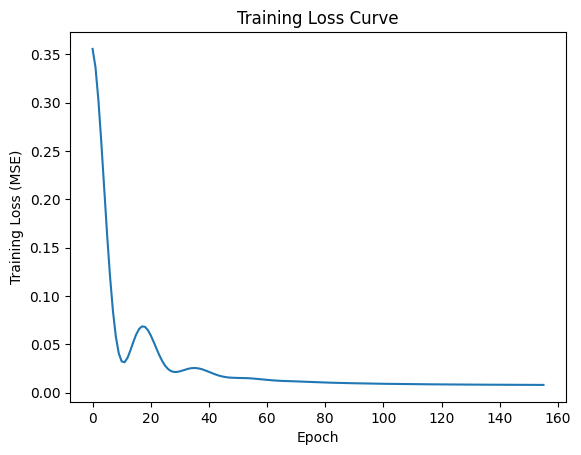

Test Loss: 0.007000 | Test Accuracy: 93.00%


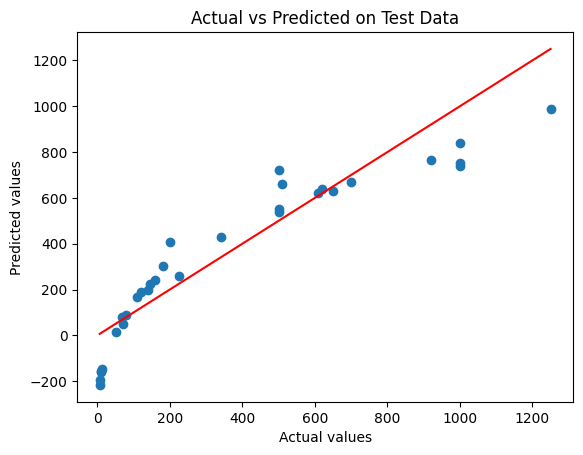

Train Loss: 0.007972 | Train Accuracy: 92.59%


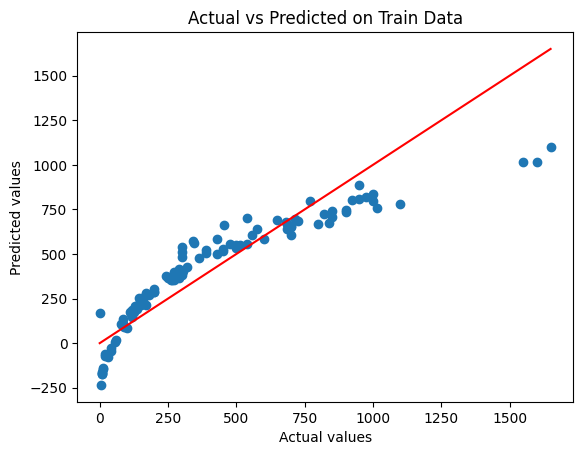

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define normalization scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Load and normalize the data using the new format
x_train = pd.read_csv("train_data.csv").values
y_train = pd.read_csv("train_label.csv").values.reshape(-1, 1)
x_test = pd.read_csv("test_data.csv").values
y_test = pd.read_csv("test_label.csv").values.reshape(-1, 1)

# Normalize features and outputs
x_train = scaler_X.fit_transform(x_train)
x_test = scaler_X.transform(x_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert numpy arrays to PyTorch tensors
X_train = torch.from_numpy(x_train).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).to(device)

X_test = torch.from_numpy(x_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).to(device)

# Define the neural network with two hidden layers
class FunctionApproximationModel(nn.Module):
    def __init__(self):
        super(FunctionApproximationModel, self).__init__()
        self.hidden_layer1 = nn.Linear(X_train.shape[1], 15)  # First hidden layer with 15 nodes
        self.hidden_layer2 = nn.Linear(15, 10)  # Second hidden layer with 10 nodes
        self.output_layer = nn.Linear(10, 1)  # Output layer for regression (1 output)

    def forward(self, x):
        h1 = torch.tanh(self.hidden_layer1(x))  # Tanh activation for first hidden layer
        h2 = torch.tanh(self.hidden_layer2(h1))  # Tanh activation for second hidden layer
        return h1, h2, self.output_layer(h2)  # Return outputs from both hidden layers and the final output

# Instantiate the model, define loss and optimizer
model = FunctionApproximationModel().to(device)
loss_fn = nn.MSELoss()  # MSE loss for function approximation
optimizer = torch.optim.SGD(model.parameters(), lr=0.007, momentum=0.9, weight_decay=0.01)  # Added weight decay for regularization

# Training loop
num_epochs = 200
train_errors = []
prev_loss = float('inf')
threshold = 0.00001  # Early stopping threshold

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    _, _, predictions = model(X_train)
    loss = loss_fn(predictions, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track training error
    train_errors.append(loss.item())

    # Early stopping condition
    loss_change = abs(prev_loss - loss.item())
    prev_loss = loss.item()

    if loss_change < threshold:
        print(f"Stopping early at epoch {epoch + 1}, loss change {loss_change:.6f} < {threshold}")
        # show_surface_plots(model, scaler_X, scaler_y)  # Plot after convergence
        break

    # Print loss and accuracy every 10 epochs
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            _, _, test_predictions = model(X_test)
            test_loss = loss_fn(test_predictions, y_test)

        # Calculate accuracy
        test_accuracy = (1 - test_loss.item() / np.mean(y_test.cpu().numpy()**2)) * 100  # Example accuracy metric

        print(f"Epoch: {epoch} | Train Loss: {loss.item():.6f} | Test Loss: {test_loss.item():.6f} | Test Accuracy: {test_accuracy:.2f}%")


# Plot the training loss curve
plt.plot(range(len(train_errors)), train_errors)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss Curve")
plt.show()

# Test the model
model.eval()
with torch.no_grad():
    _, _, predictions = model(X_test)
    test_loss = loss_fn(predictions, y_test)
    test_accuracy = (1 - test_loss.item() / np.mean(y_test.cpu().numpy()**2)) * 100  # Example accuracy metric
    print(f"Test Loss: {test_loss.item():.6f} | Test Accuracy: {test_accuracy:.2f}%")

# Denormalize and visualize the prediction vs actual for test data
predicted_test = scaler_y.inverse_transform(predictions.cpu().numpy())
actual_test = scaler_y.inverse_transform(y_test.cpu().numpy())

plt.scatter(actual_test, predicted_test)
plt.plot([min(actual_test), max(actual_test)], [min(actual_test), max(actual_test)], color='red')  # Reference line
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted on Test Data')
plt.show()

# --------------------- Add Actual vs Predicted on Train Data -----------------------

# Get predictions on the training data
with torch.no_grad():
    _, _, train_predictions = model(X_train)
    train_loss = loss_fn(train_predictions, y_train)
    train_accuracy = (1 - train_loss.item() / np.mean(y_train.cpu().numpy()**2)) * 100  # Example accuracy metric
    print(f"Train Loss: {train_loss.item():.6f} | Train Accuracy: {train_accuracy:.2f}%")

# Denormalize and visualize the prediction vs actual for train data
predicted_train = scaler_y.inverse_transform(train_predictions.cpu().numpy())
actual_train = scaler_y.inverse_transform(y_train.cpu().numpy())

plt.scatter(actual_train, predicted_train)
plt.plot([min(actual_train), max(actual_train)], [min(actual_train), max(actual_train)], color='red')  # Reference line
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted on Train Data')
plt.show()
